In [1]:
import requests
import pandas as pd

#ignore all warnings
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
from dateutil.relativedelta import relativedelta
from dateutil import rrule
import time
import itertools
import matplotlib.pyplot as plt

#### Function returns list of end of month dates

In [2]:
def daterange(d1, d2):
    # count numbero f months between two dates, excluding the final date
    monthcount = (d2.year - d1.year) * 12 + d2.month - d1.month

    # convert start month to the first of next months
    d1 = d1 + relativedelta(months=1)
    d1 = datetime(d1.year, d1.month, 1)
    months = list(rrule.rrule(rrule.MONTHLY, dtstart=d1, count=monthcount))
    months = [i - timedelta(1) for i in months]
    return months

## Read fiscal textfile for the specified date
#### If available, returns the, end of month and fiscal year to date total marketable and nonmarketable issues  (from Table III-A, Public Debt Transactions).

In [3]:
def readtxt(date):
    str_date = date.strftime('%y%m%d')
    f = str_date + '00.txt'
    url = 'https://fsapps.fiscal.treasury.gov/dts/files/' + f
    # print(url)
    r = requests.get(url, allow_redirects=True)
    open('data/' + f, 'wb').write(r.content)

    temp = open('data/'+f, 'r')

    # First we find the start and end lines of the table of interest
    start_table_line = 0
    for line in temp:
        if 'TABLE III-A  Public Debt Transactions' in line: #start of table is found
            #reopen file
            temp = open('data/' + f, 'r')
            end_table_line = start_table_line + 7
            for table_line in itertools.islice(temp, start_table_line+7, None):
                if '__________' in table_line:
                    break
                end_table_line += 1
            break
        start_table_line += 1

    #reopen the file
    temp = open('data/' + f, 'r')
    nonmarketable_ind = False # indicator for nonmarketable debt.
    marketable = [0, 0]
    nonmarketable = [0, 0]
    total_issues = []
    for line in itertools.islice(temp, start_table_line, end_table_line):
        line = line.replace('\n', '')
        line = line.replace(',', '')
        line = line.replace('$', '')

        if 'Total Issues' in line:
            digits = [int(s) for s in line.split() if s.isdigit()]
            total_issues = digits[1:]
            break
        if 'Nonmarketable:' in line:
            nonmarketable_ind = True
            continue

        digits = [int(s) for s in line.split() if s.isdigit()]
        if len(digits) == 3:
            if not nonmarketable_ind:
                marketable = [sum(x) for x in zip(marketable, digits[1:])]
                continue
            nonmarketable = [sum(x) for x in zip(nonmarketable, digits[1:])]

    return marketable, nonmarketable, total_issues

# Initialisation and start

In [11]:
start_date = datetime(2005, 6, 1)
end_date = date.today()
dates = daterange(start_date, end_date)


# x = readtxt(start_date)
marketable = pd.DataFrame(index = dates, columns=['MtD', 'YtD'])
nonmarketable = pd.DataFrame(index = dates, columns=['MtD', 'YtD'])
total = pd.DataFrame(index = dates, columns=['MtD', 'YtD'])
for single_date in dates:
    count = 0
    start = time.time()
    datefinder = True
    
    while datefinder:
        #print(single_date)
        try:
            output = readtxt(single_date)
            marketable.loc[single_date] = output[0]
            nonmarketable.loc[single_date] = output[1]
            total.loc[single_date] = output[2]
            datefinder = False
        # If an error occurs, try one date earlier
        except:
            #print('error at ' + str(single_date))
            single_date = single_date - timedelta(days=1)
            count += 1
            # try maximum of 6 dates, otherwise just go to the next month (this should only happen is there are no txtfiles available)
            if count > 6:
                break
    #print(single_date.strftime('%B %Y') + ' completed, '+ str(round(time.time() - start, 2))+'s')


marketable = marketable.sort_index().dropna().astype(float)
nonmarketable = nonmarketable.sort_index().dropna().astype(float)
total = total.sort_index().dropna().astype(float)


# Marketable Issues
### Consists among others of US Treasury bills, notes, bonds, TIPS

In [46]:
ustga = pd.read_csv('ustga.csv', index_col=0)
ustga.index = pd.to_datetime(ustga.index)
ustga = ustga['ustga'] / 1000

In [38]:
ustga

date
1/8/1986     0.004140
1/15/1986    0.005032
1/22/1986    0.013856
1/29/1986    0.017487
2/5/1986     0.012475
               ...   
6/17/2020    1.560850
6/24/2020    1.623942
7/1/2020     1.657620
7/8/2020     1.653098
7/15/2020    1.655320
Name: ustga, Length: 1802, dtype: float64

In [45]:
marketable.to_csv('marketable.csv')
nonmarketable.to_csv('nonmarketable.csv')
total.to_csv('total.csv')

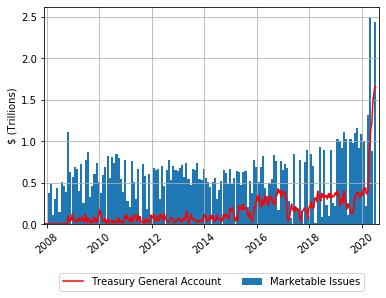

In [63]:
marketable2 = marketable['2008-01-01':]

fig, ax = plt.subplots()
# marketable issues plot
ax.bar(marketable2.index, marketable2['MtD'] / 1000 / 1000 , width=30, label='Marketable Issues')
ax.xaxis_date()
plt.xlim(marketable2.index[0] - relativedelta(months=2), marketable2.index[-1]+ relativedelta(months=2))
plt.ylabel('$ (Trillions)')
plt.plot(ustga, color='r', label='Treasury General Account')
#plt.title('Marketable issues')
plt.xticks(rotation=40)
plt.grid()
plt.legend(loc=9, bbox_to_anchor=(0.5, -.2), ncol=2)


plt.savefig(r'marketable.png', bbox_inches='tight', dpi=400)
plt.show()

An increase in new Treasury issues led to a huge increase of the treasury general account. There is still a lot of money to be spend.

# Nonmarketable Issues
### Consists mostly of government account series (intergovernmental debt)

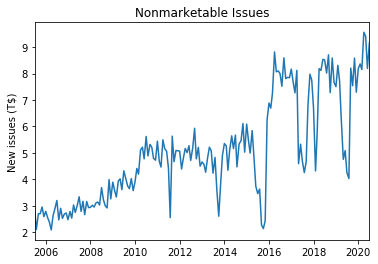

In [44]:
fig, ax = plt.subplots()
#non marketable issues plot
#ax.bar(nonmarketable.index, nonmarketable['MtD'] / 1000 / 1000 , width=20)
#ax.xaxis_date()

plt.plot(nonmarketable['MtD'] / 1000 / 1000)
plt.xlim(nonmarketable.index[0], nonmarketable.index[-1])
plt.ylabel('New issues (T$)')
plt.title('Nonmarketable Issues')
plt.show()

# Total Issues

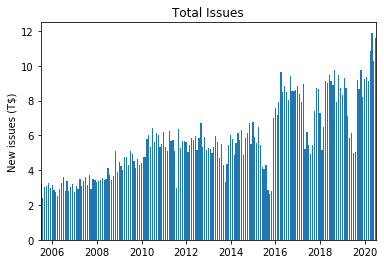

In [14]:
fig, ax = plt.subplots()
#non marketable issues plot
ax.bar(total.index, total['MtD'] / 1000 / 1000 , width=20)
ax.xaxis_date()
plt.xlim(total.index[0], total.index[-1])
plt.ylabel('New issues (T$)')
plt.title('Total Issues')
plt.show()